In [1]:
# Import required packages
import torch
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

In [7]:
help(nf.flows.Permute)

Help on class Permute in module normflows.flows.mixing:

class Permute(normflows.flows.base.Flow)
 |  Permute(num_channels, mode='shuffle')
 |  
 |  Permutation features along the channel dimension
 |  
 |  Method resolution order:
 |      Permute
 |      normflows.flows.base.Flow
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, num_channels, mode='shuffle')
 |      Constructor
 |      :param num_channel: Number of channels
 |      :param mode: Mode of permuting features, can be shuffle for
 |      random permutation or swap for interchanging upper and lower part
 |  
 |  forward(self, z)
 |      :param z: input variable, first dimension is batch dim
 |      :return: transformed z and log of absolute determinant
 |  
 |  inverse(self, z)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from torch.nn.modules.module.Module:
 |  
 |  __call__ = _call_impl(self, *input,

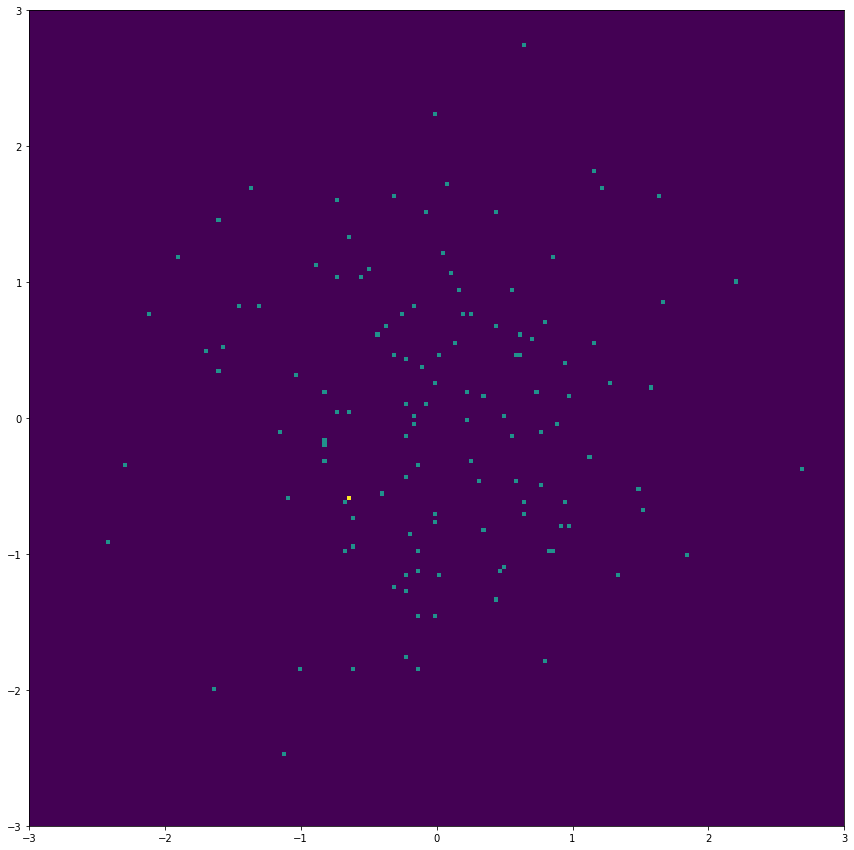

In [2]:
# Set up model

# Define flows
K = 64
torch.manual_seed(0)

latent_size = 2
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(K):
    s = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]

# Set prior and q0
prior = nf.distributions.TwoModes(2, 0.1)
q0 = nf.distributions.DiagGaussian(2)

# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=prior)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)
nfm = nfm.double()

# Initialize ActNorm
z, _ = nfm.sample(num_samples=2 ** 7)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(15, 15))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (200, 200), range=[[-3, 3], [-3, 3]])
plt.gca().set_aspect('equal', 'box')
plt.show()

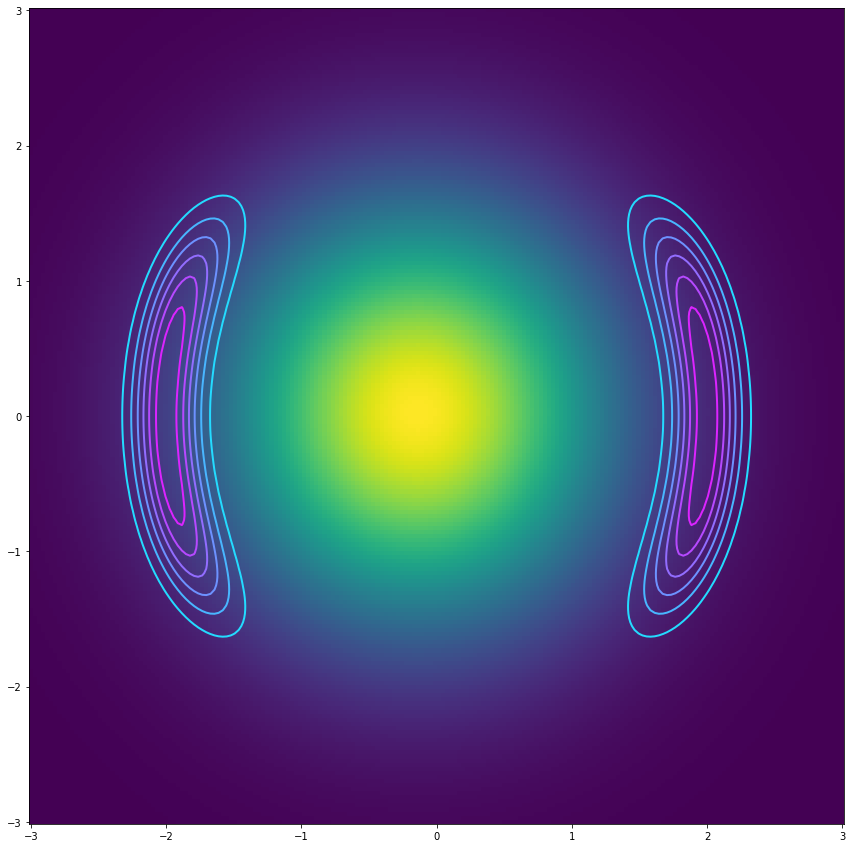

In [3]:
# Plot prior distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.double().to(device)
log_prob = prior.log_prob(zz).to('cpu').view(*xx.shape)
prob_prior = torch.exp(log_prob)

# Plot initial posterior distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_prior.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

  5%|▍         | 999/20000 [02:08<50:26,  6.28it/s]  

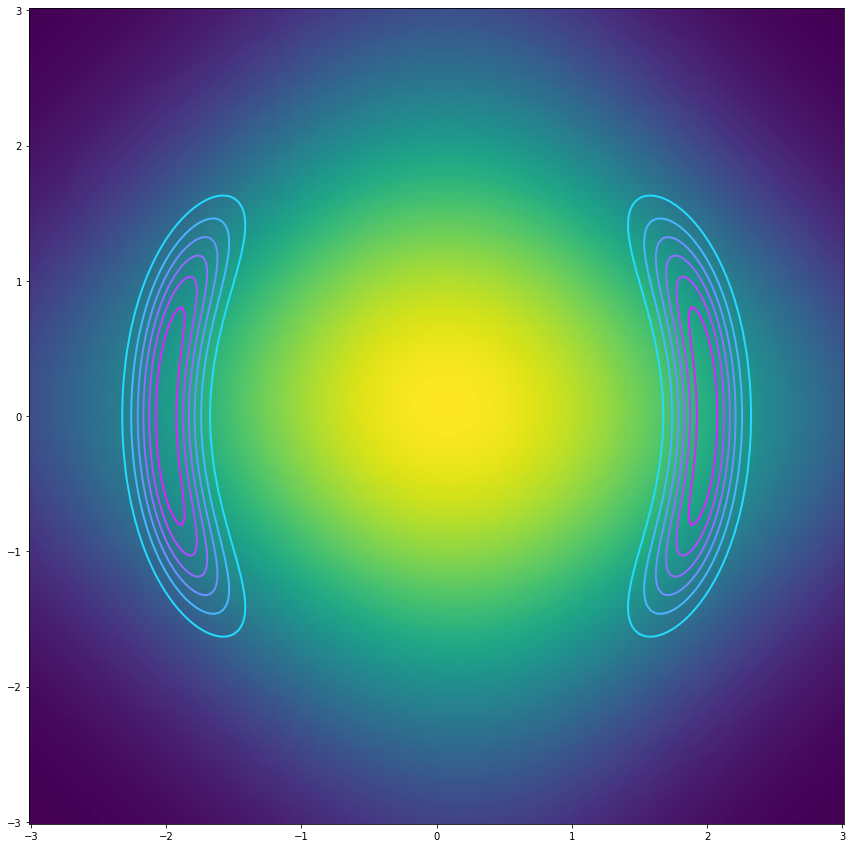

 10%|▉         | 1999/20000 [04:08<33:53,  8.85it/s]  

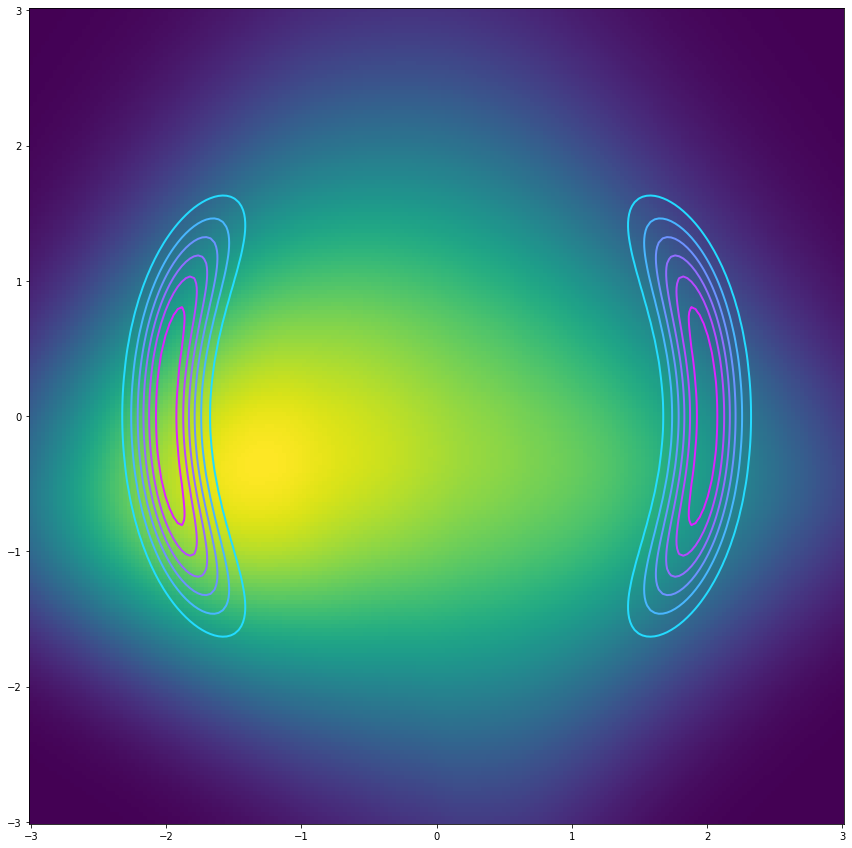

 15%|█▍        | 2999/20000 [06:10<36:03,  7.86it/s]  

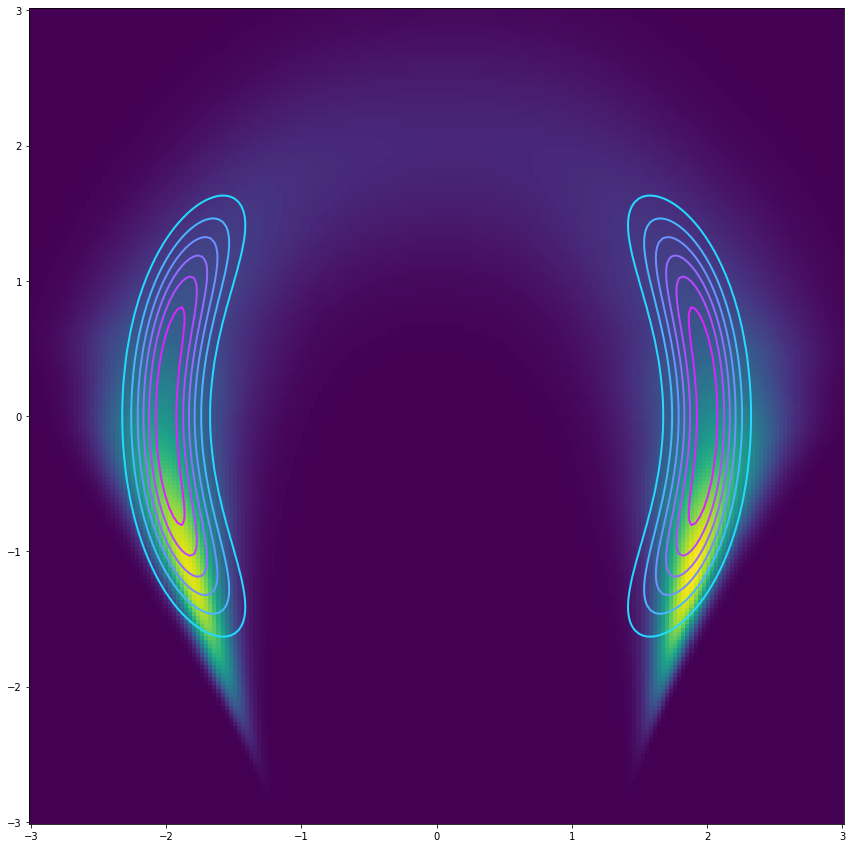

 20%|█▉        | 3999/20000 [08:08<30:30,  8.74it/s]  

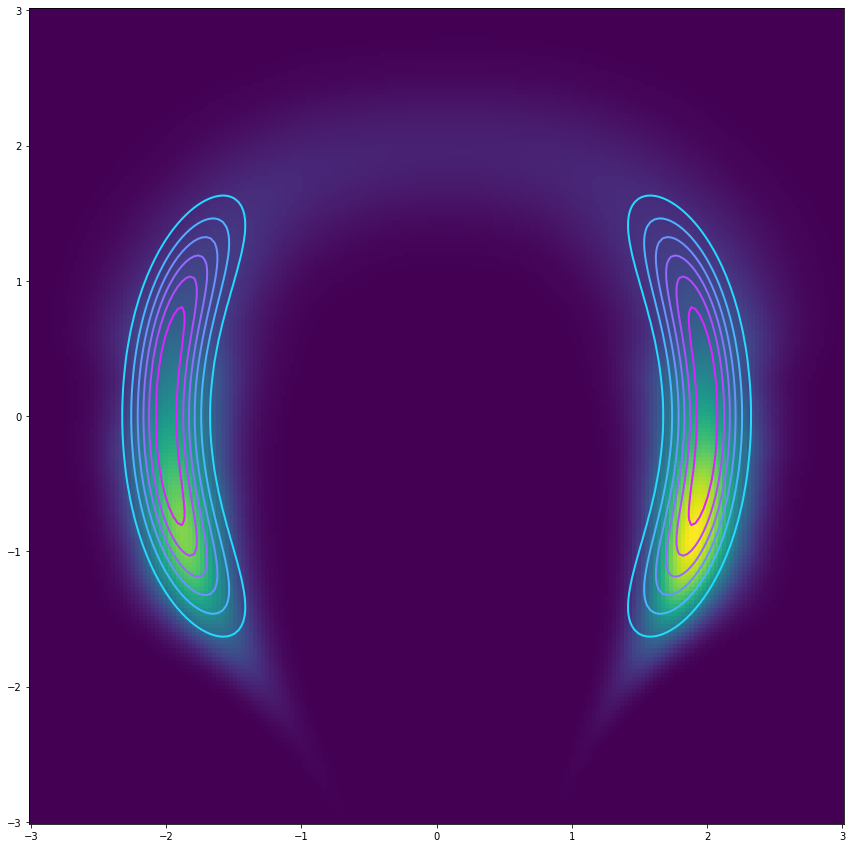

 25%|██▍       | 4999/20000 [10:05<29:10,  8.57it/s]  

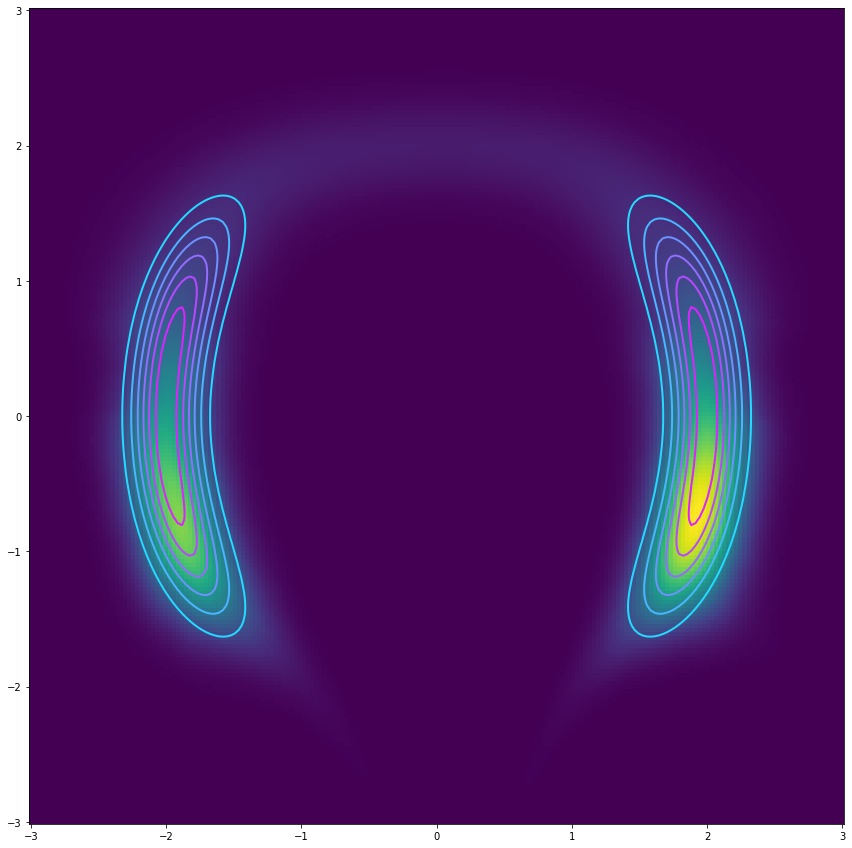

 30%|██▉       | 5999/20000 [12:03<26:34,  8.78it/s]  

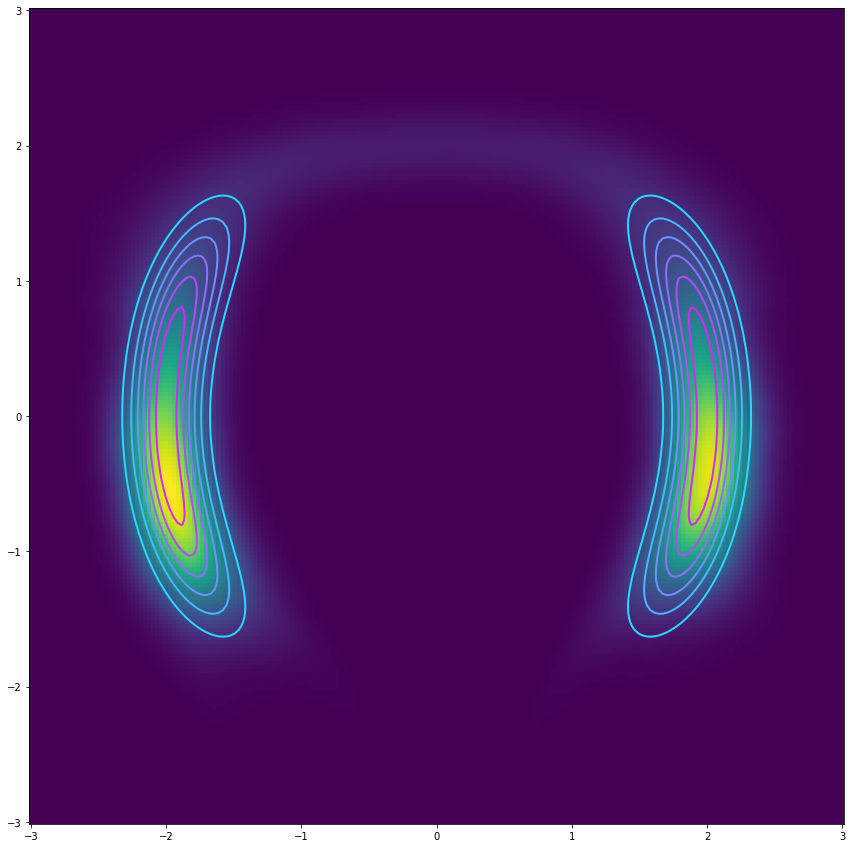

 35%|███▍      | 6999/20000 [14:01<24:01,  9.02it/s]  

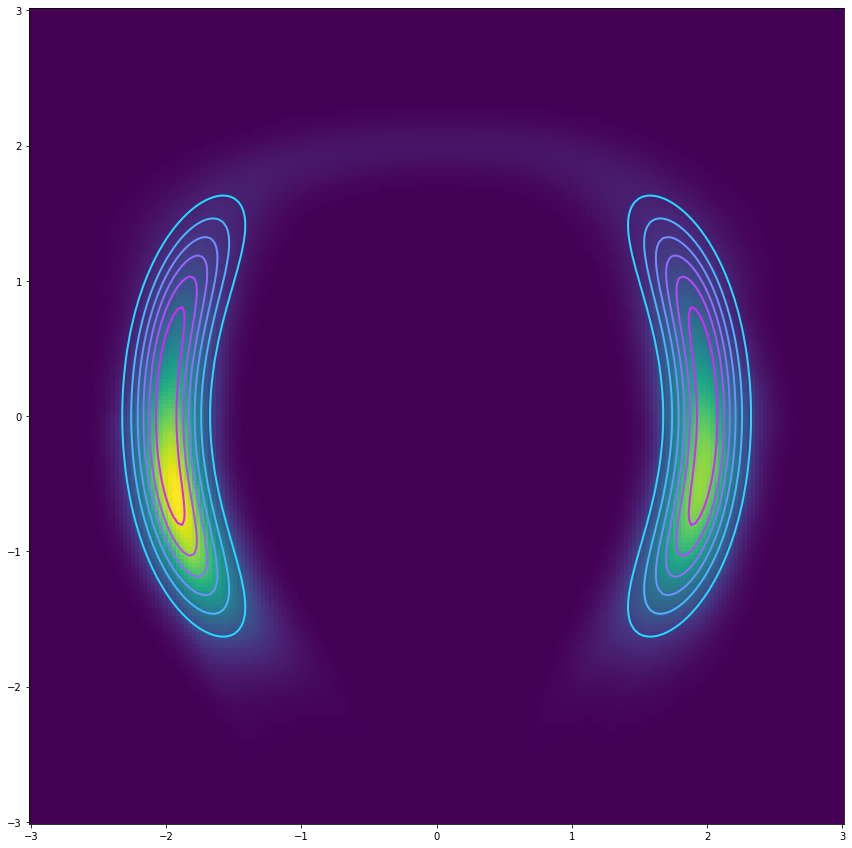

 40%|███▉      | 7999/20000 [15:59<22:55,  8.73it/s]

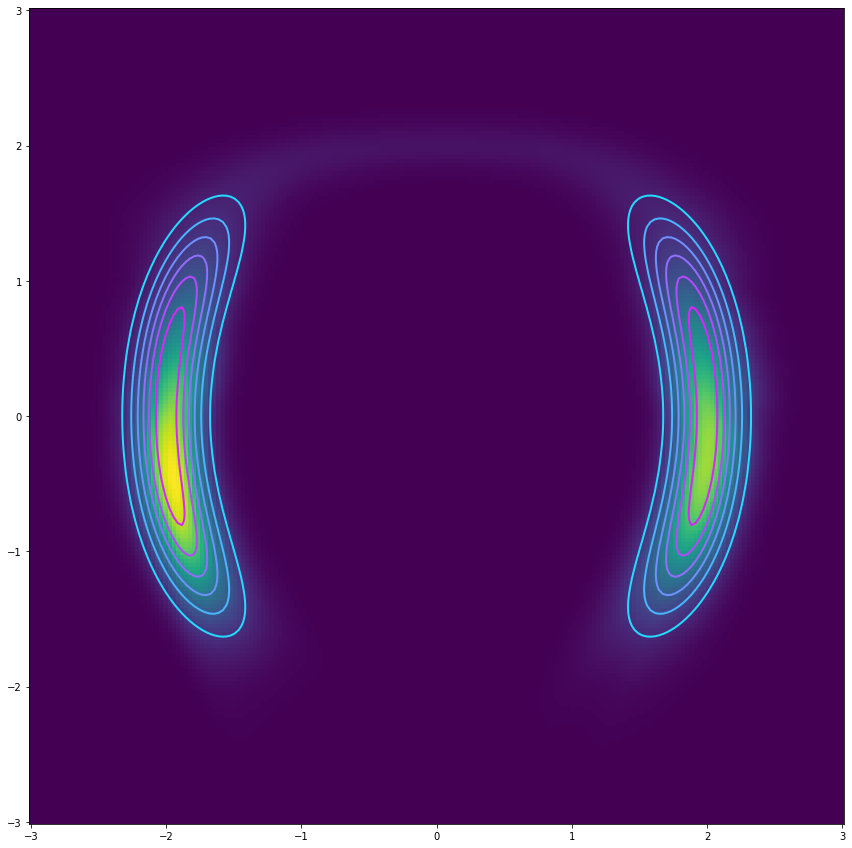

 45%|████▍     | 8999/20000 [17:57<21:17,  8.61it/s]

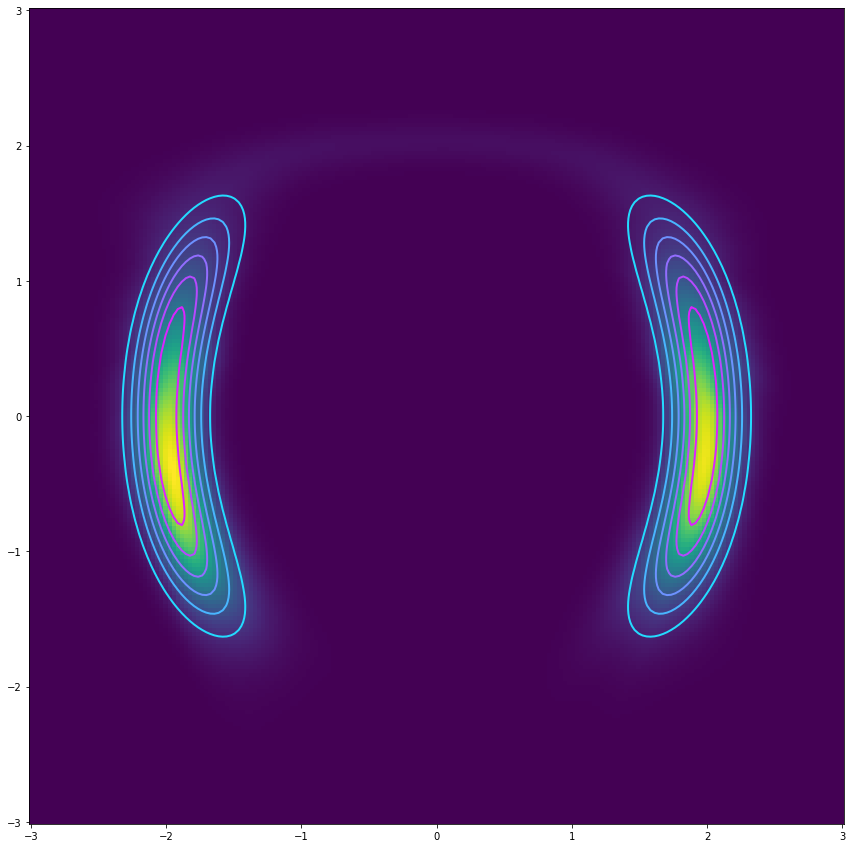

 50%|████▉     | 9999/20000 [19:56<18:42,  8.91it/s]

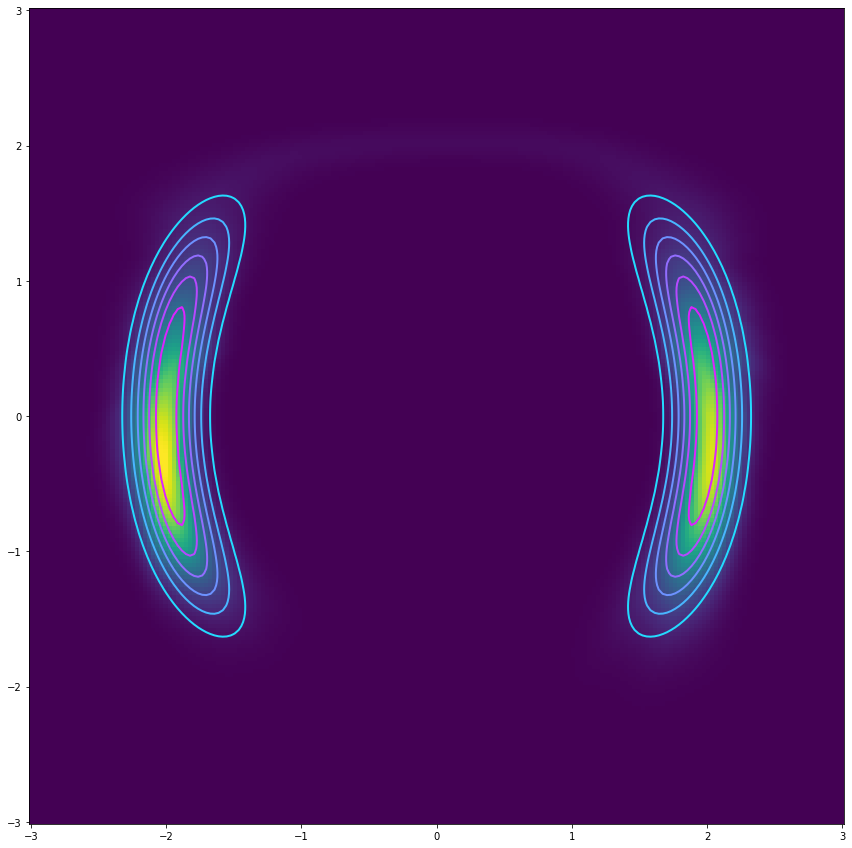

 55%|█████▍    | 10999/20000 [21:54<17:51,  8.40it/s]

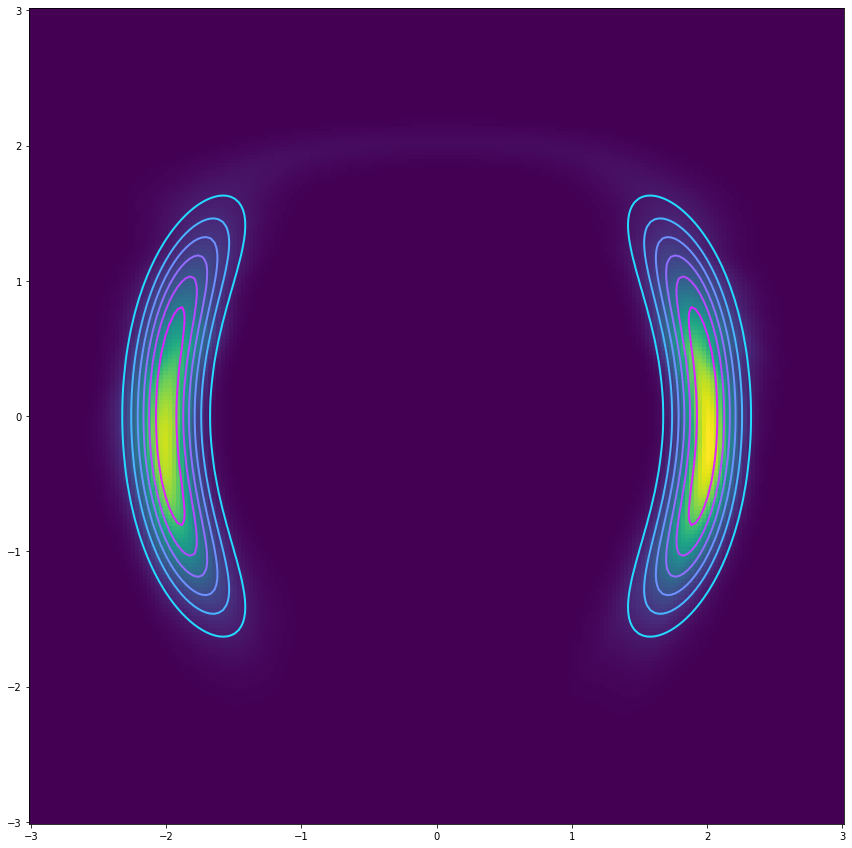

 60%|█████▉    | 11999/20000 [23:53<15:48,  8.43it/s]

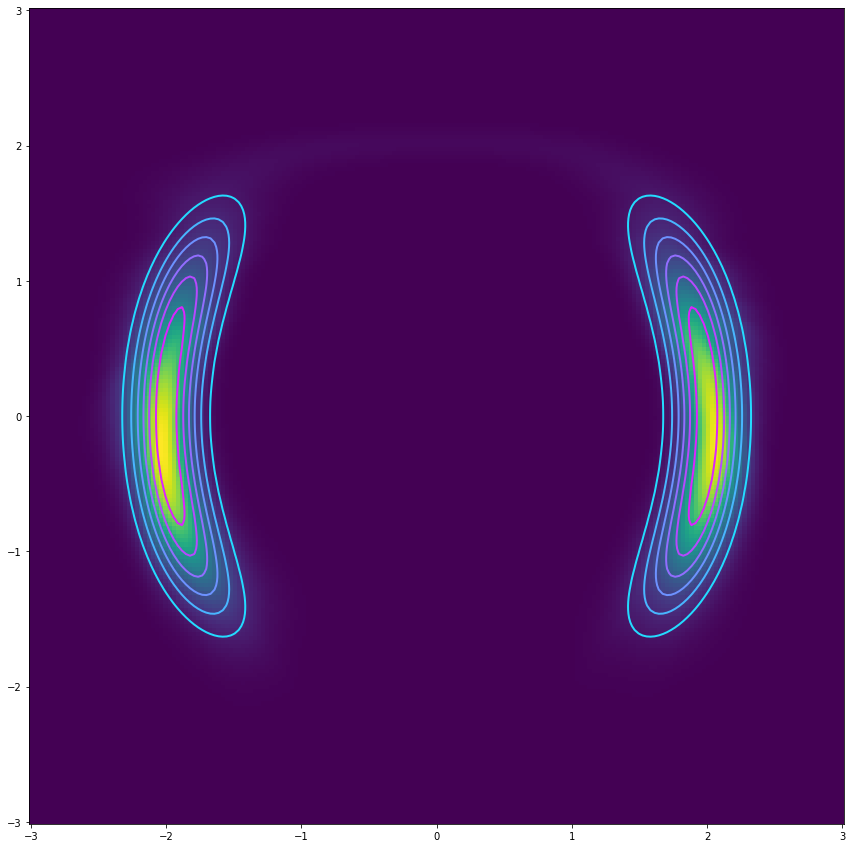

 65%|██████▍   | 12999/20000 [25:51<13:03,  8.93it/s]

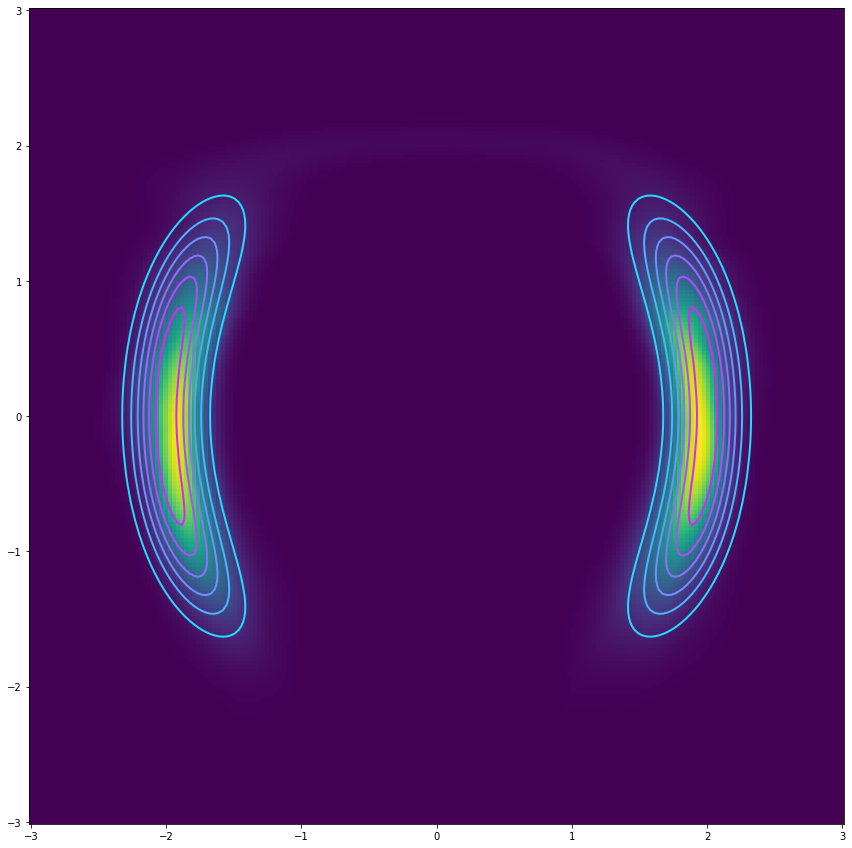

 70%|██████▉   | 13999/20000 [27:50<11:38,  8.59it/s]

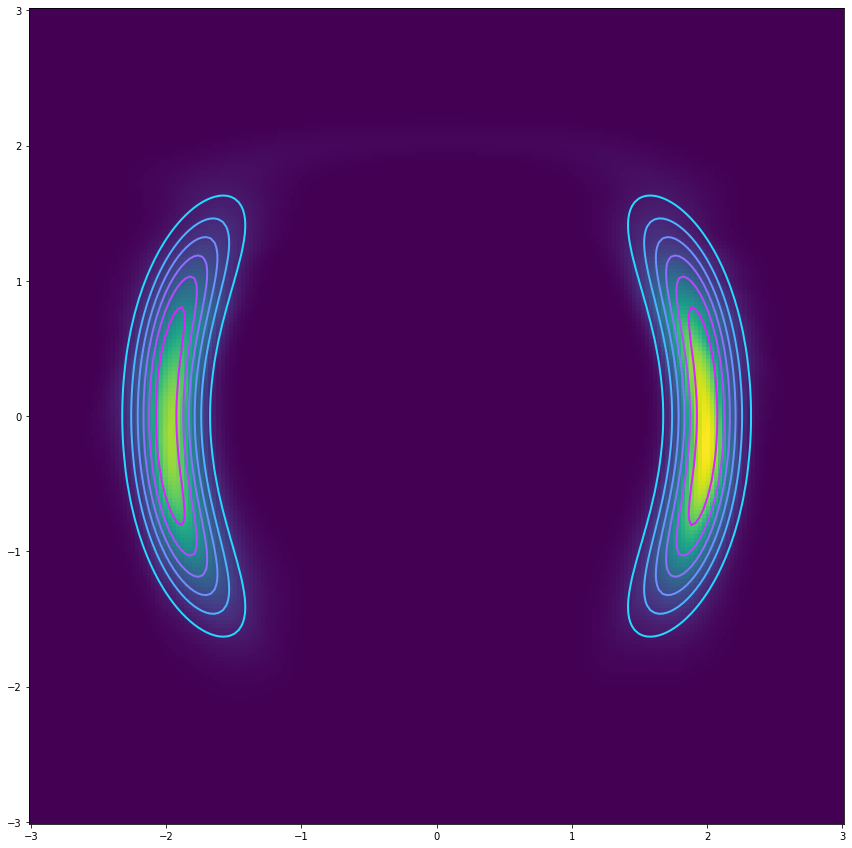

 75%|███████▍  | 14999/20000 [29:48<09:23,  8.87it/s]

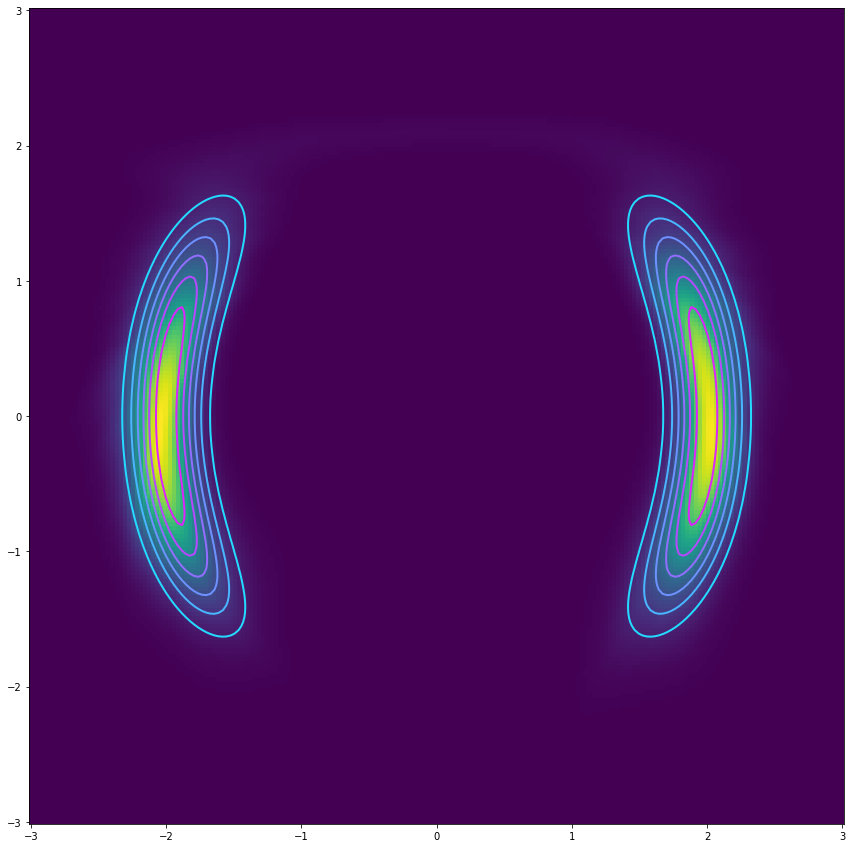

 80%|███████▉  | 15999/20000 [31:48<08:11,  8.14it/s]

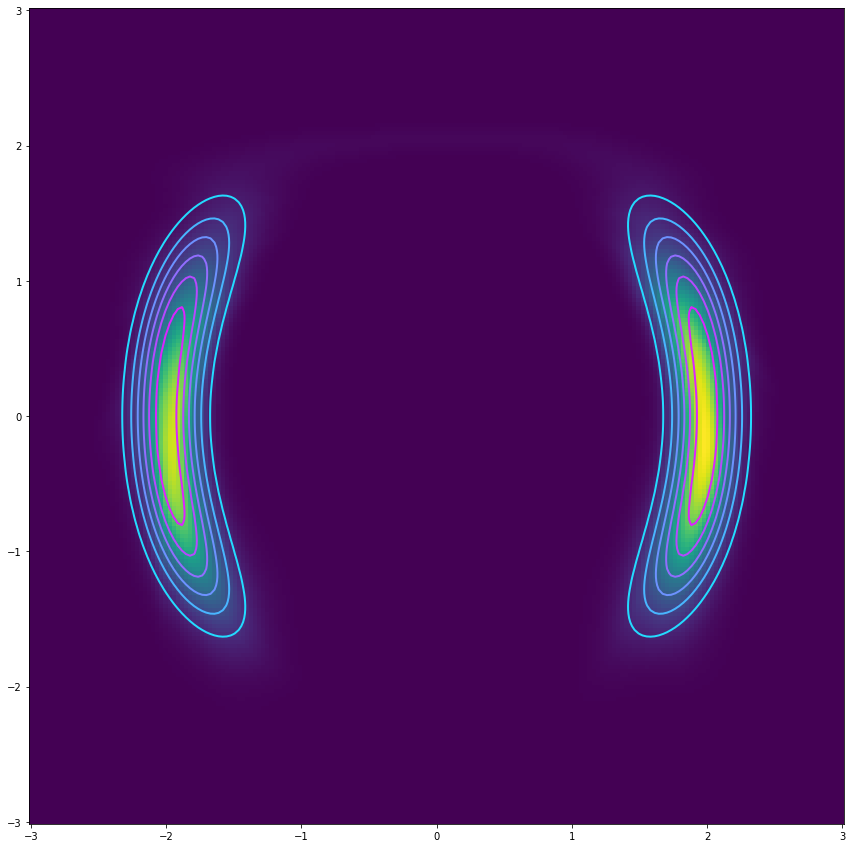

 85%|████████▍ | 16999/20000 [33:47<05:45,  8.70it/s]

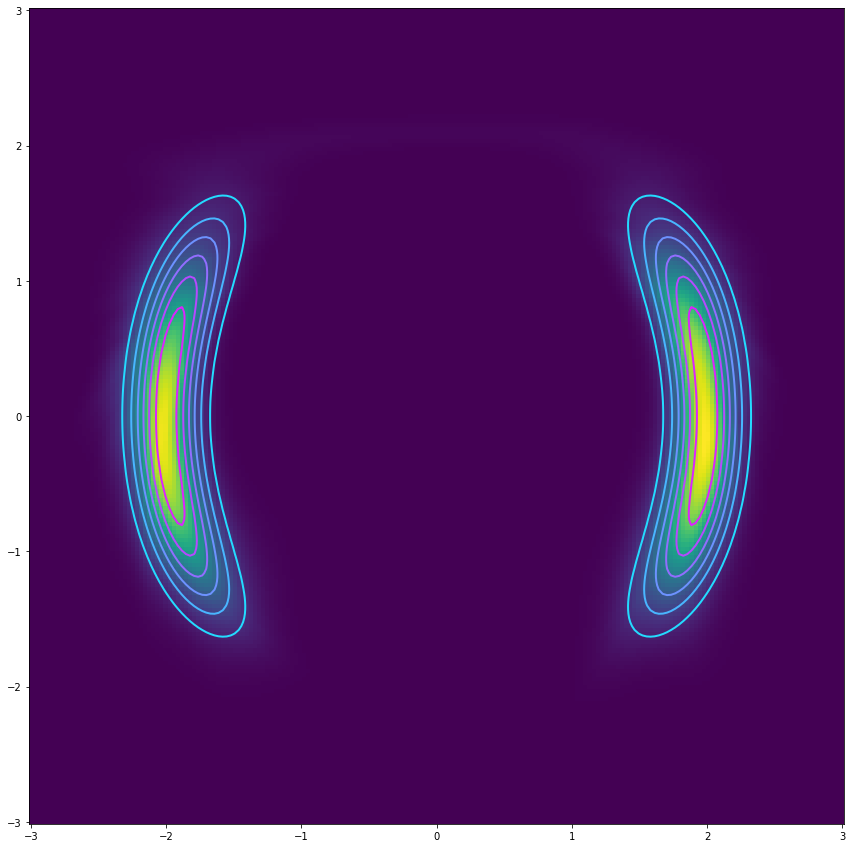

 90%|████████▉ | 17999/20000 [35:45<03:54,  8.53it/s]

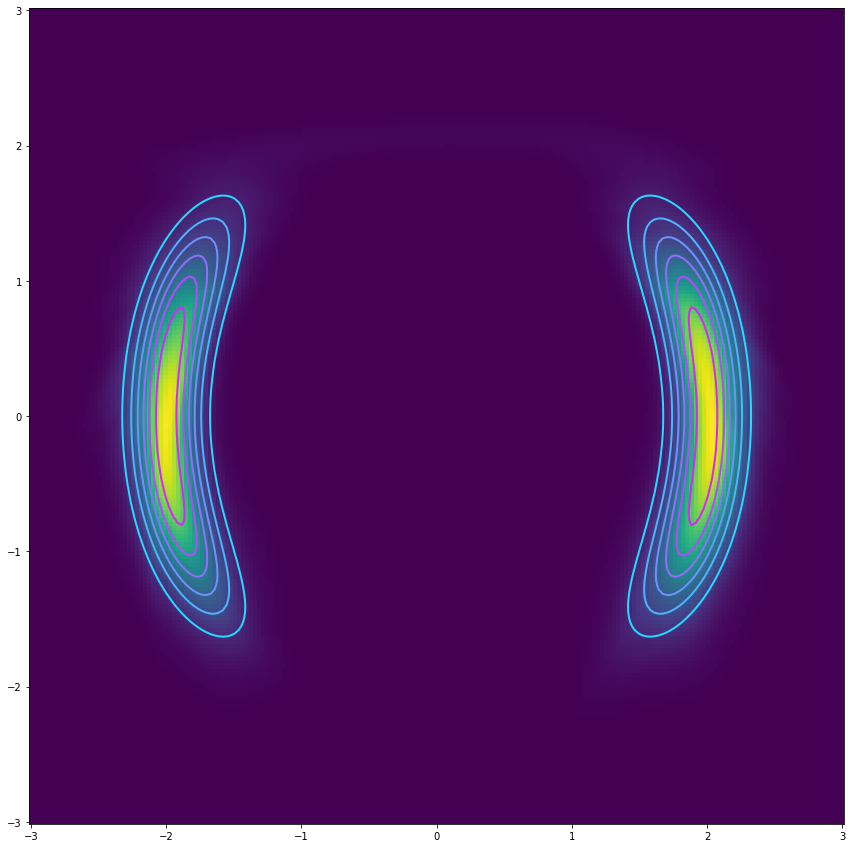

 95%|█████████▍| 18999/20000 [37:43<01:57,  8.49it/s]

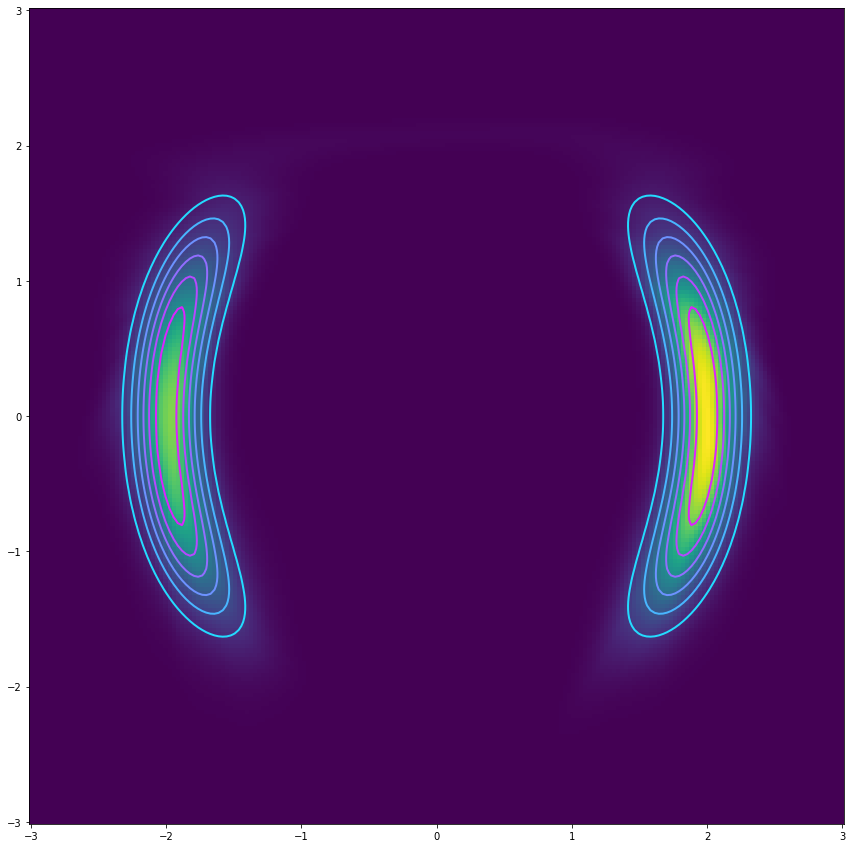

100%|█████████▉| 19999/20000 [39:42<00:00,  8.90it/s]

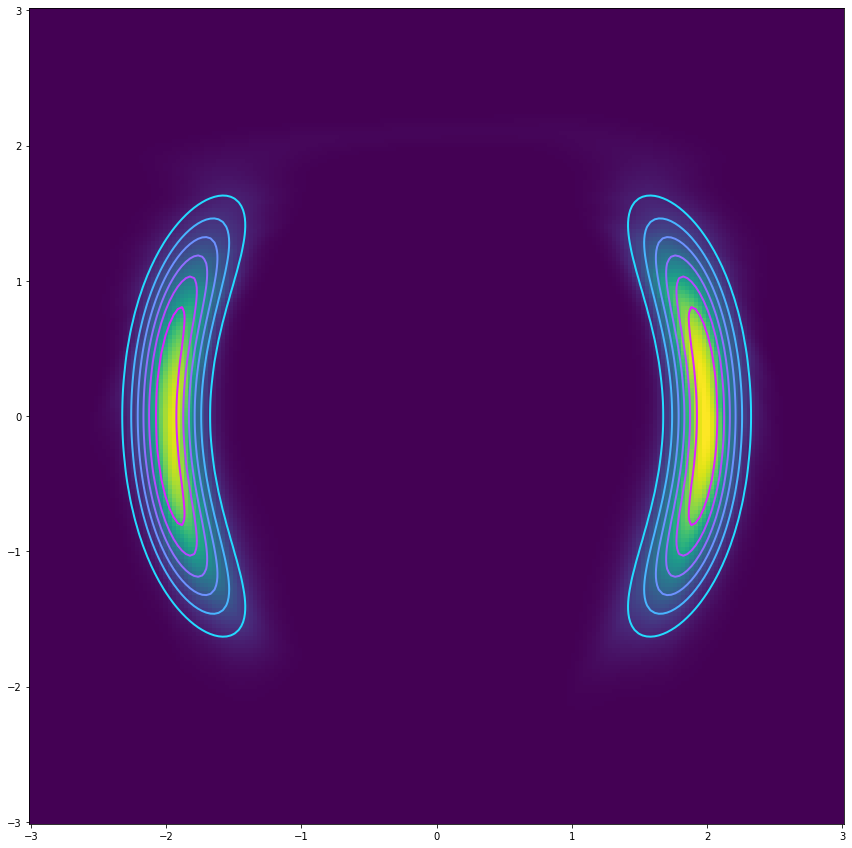

100%|██████████| 20000/20000 [39:42<00:00,  8.39it/s]


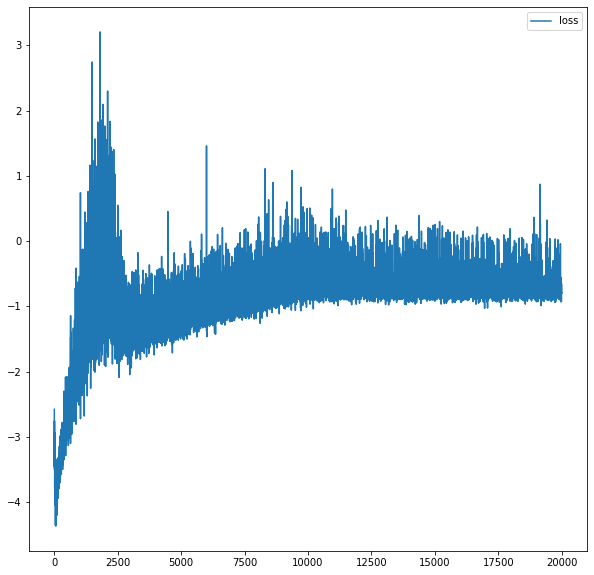

In [4]:
# Train model
max_iter = 20000
num_samples = 2 * 10
anneal_iter = 10000
annealing = True
show_iter = 1000


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-4, weight_decay=1e-6)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = nfm.reverse_kld(num_samples, beta=np.min([1., 0.001 + it / anneal_iter]))
    else:
        loss = nfm.reverse_alpha_div(num_samples, dreg=True, alpha=1)
    
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned posterior
    if (it + 1) % show_iter == 0:
        log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
        prob = torch.exp(log_prob)
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.contour(xx, yy, prob_prior.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
        plt.gca().set_aspect('equal', 'box')
        plt.show()

plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

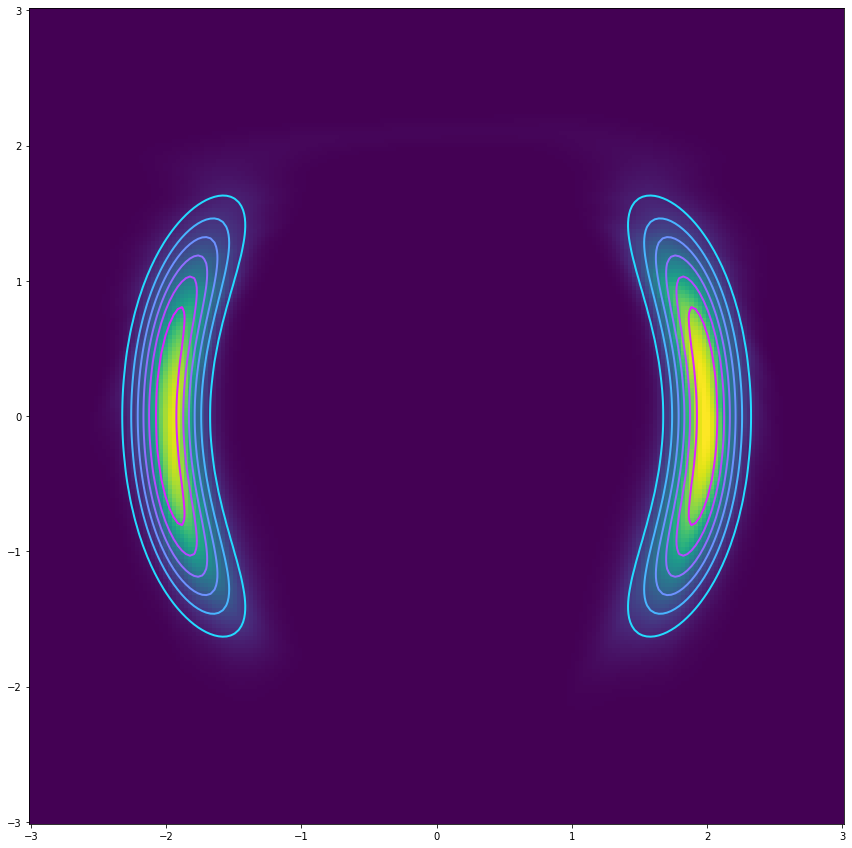

In [5]:
# Plot learned posterior distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_prior.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()